# Lab 3: Joining Multiple Tables (Python & Pandas)

In class, we've explored the power of tables as a data management abstraction, and we have already explored the Pandas DataFrame object in previous lab 2. Tables let us select rows and columns of interest, group data, and measure aggregates.

But what happens when we have more than one table? Traditional relational databases usually contain many tables. Moreover, when integrating multiple data sets, we necessarily need tools to combine them.

In this lab, we will use Panda's take on the database join operation to see how tables can be linked together. Specifically, we're going to perform a "fuzzy join" based on string edit-distance as another approach to finding duplicate records.

## Setup

#### This notebook

Download this notebook so you can edit it. (If you are viewing it via nbviewer.ipython.org, then use the link in the upper right corner.) To edit this notebook, in your VM terminal, type "ipython notebook" and in your prompted brower, click the notebook file to open and edit it.

#### Data

We'll be using a small data set of restaurants. Download the data from [here](https://ufl.instructure.com/courses/344204/files/folder/Labs/Lab%203). Put the data file, "restaurants.csv", in the same directory as this notebook.

#### Edit Distance

We're going to be using a string-similarity python library to compute "edit distance".

To test that it works, the following should run OK:

In [3]:
import Levenshtein as L

## More Operations on DataFrame

In previous lab, we have learned some basic operation on Pandas DataFrame, including row filtering (selection), column filtering (projection) and groupby.

In this lab we first introduce some additional operation.

#### Aggregate

You should probably know to do aggregates: Pandas use python's lambda functions to define the function, and 'apply' to use the function.

In [4]:
import pandas as pd
df = pd.DataFrame( { 'a' : [1, 2, 1, 2], 'b': [ 'x', 'x', 'y', 'y'] })
df

,a,b
0,1,x
1,2,x
2,1,y
3,2,y


In [5]:
df['value'] = df.apply(lambda row: str(row.a) + ' + ' + row.b, axis=1)
df

,a,b,value
0,1,x,1 + x
1,2,x,2 + x
2,1,y,1 + y
3,2,y,2 + y


#### Pivot

Suppose we want to reshape the above DataFrame, so that in the new DataFrame we can have an index of different values in 'a' column to identify rows, and unique values in 'b' as column names. We can use **pivot** function to achieve this:

In [6]:
new_df = df.pivot(index='a', columns='b', values='value')
new_df

b,x,y
a,,
1,1 + x,1 + y
2,2 + x,2 + y


## Joins

A **join** is a way to connect rows in two different data tables based on some criteria. Suppose the university has a database for student records with two tables in it: Students and Grades.

In [7]:
Students = pd.DataFrame({'student_id': [1, 2], 'name': ['Alice', 'Bob']})
Students

,name,student_id
0,Alice,1
1,Bob,2


In [8]:
Grades = pd.DataFrame({'student_id': [1, 1, 2, 2], 'class_id': [1, 2, 1, 3], 'grade': ['A', 'C', 'B', 'B']})
Grades

,class_id,grade,student_id
0,1,A,1
1,2,C,1
2,1,B,2
3,3,B,2


Let's say we want to know all of Bob's grades. Then, we can look up Bob's student ID in the Students table, and with the ID, look up his grades in the Grades table. Joins naturally express this process: when two tables share a common type of column (student ID in this case), we can join the tables together to get a complete view.

In Pandas, we can use the **merge** method to perform a join. Pass the two tables to join as the first arguments, then the "on" parameter is set to the join column name.

In [9]:
pd.merge(Students, Grades, on='student_id')

,name,student_id,class_id,grade
0,Alice,1,1,A
1,Alice,1,2,C
2,Bob,2,1,B
3,Bob,2,3,B


**Question 1**

Use merge to join Grades with the Classes table below, and find out what class Alice got an A in.

In [11]:
Classes = pd.DataFrame({'class_id': [1, 2, 3], 'title': ['Math', 'English', 'Spanish']})
# Your answer here:
cg_table = pd.merge(Classes, Grades, on='class_id')
cg_table

,class_id,title,grade,student_id
0,1,Math,A,1
1,1,Math,B,2
2,2,English,C,1
3,3,Spanish,B,2


**Question 2**

Suppose we want to get students' grades for each class in a more straightforward way, and decide to get a Dataframe that: 

1. has one row for each student name, 
2. different class titles as columns names,
3. the grades of students in different classes as the values (NaN if not applicable).

how do we get such a DataFrame?

In [18]:
# Your answer here:
cgs_table = pd.merge(cg_table, Students, on='student_id')
cgs_table = cgs_table.pivot(index='name', columns='title', values='grade')
from numpy import nan
cgs_table.fillna(value=nan, inplace=True)
cgs_table

title,English,Math,Spanish
name,,,
Alice,C,A,NaN
Bob,NaN,B,B


## Joining the Restaurant Data

Now let's load the restaurant data that we will be analyzing:

In [21]:
resto = pd.read_csv('restaurants.csv')
resto.info()
resto.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 858 entries, 0 to 857
Data columns (total 4 columns):
id         858 non-null int64
cluster    858 non-null int64
name       858 non-null object
city       858 non-null object
dtypes: int64(2), object(2)
memory usage: 26.9+ KB


,id,cluster,name,city
0,560,453,2223,san francisco
1,781,675,103 west,atlanta
2,279,172,20 mott,new york
3,43,23,21 club,new york
4,44,23,21 club,new york city


In [ ]:
resto[:10]

The restaurant data has four columns. **id** is a unique ID field (unique for each row), **name** is the name of the restaurant, and **city** is where it is located. The **name** and **city** columns are noisy and not very accurate.

However the **cluster** column is a "gold standard" column. If two records have the same cluster, that means they are both about the same restaurant.

The type of join we made above between Students and Grades, where we link records with equal values in a common column, is called an **equijoin**. Equijoins may join on more than one column, too (both values have to match).

Let's use an equijoin to find pairs of duplicate restaurant records. We join the data to itself, on the cluster column.

The result ("clusters" below) has a lot of extra records in it. For example, since we're joining a table to itself, every record matches itself. We can filter on IDs to get rid of these extra join results. Note that when Pandas joins two tables that have columns with the same name, it appends "_x" and "_y" to the names to distinguish them.

In [26]:
clusters = pd.merge(resto, resto, on='cluster')
clusters.head(10)
clusters = clusters[clusters.id_x != clusters.id_y]
clusters.head(10)

,id_x,cluster,name_x,city_x,id_y,name_y,city_y
4,43,23,21 club,new york,44,21 club,new york city
5,44,23,21 club,new york city,43,21 club,new york
10,145,74,abruzzi,atlanta,146,abruzzi,atlanta
11,146,74,abruzzi,atlanta,145,abruzzi,atlanta
20,184,94,alain rondelli,san francisco,185,alain rondelli,san francisco
21,185,94,alain rondelli,san francisco,184,alain rondelli,san francisco
36,186,95,aqua,san francisco,187,aqua,san francisco
37,187,95,aqua,san francisco,186,aqua,san francisco
40,45,24,aquavit,new york,46,aquavit,new york city
41,46,24,aquavit,new york city,45,aquavit,new york


There are still redundant records in 'clusters' above: if records A and B match each other, then we will get both (A, B) and (B, A) in the output, this is redundant since we don't care about the order of A and B.

Filter clusters so that we only keep one instance of each matching pair (HINT: use the IDs again).

In [27]:
clusters = clusters[clusters.id_x > clusters.id_y]
clusters.head(10)

,id_x,cluster,name_x,city_x,id_y,name_y,city_y
5,44,23,21 club,new york city,43,21 club,new york
11,146,74,abruzzi,atlanta,145,abruzzi,atlanta
21,185,94,alain rondelli,san francisco,184,alain rondelli,san francisco
37,187,95,aqua,san francisco,186,aqua,san francisco
41,46,24,aquavit,new york city,45,aquavit,new york
47,2,0,arnie morton's of chicago,los angeles,1,arnie morton's of chicago,los angeles
50,4,1,art's deli,studio city,3,art's delicatessen,studio city
59,48,25,aureole,new york city,47,aureole,new york
63,148,75,bacchanalia,atlanta,147,bacchanalia,atlanta
78,6,2,bel-air hotel,bel air,5,hotel bel-air,bel air


## Fuzzy Joins

Sometimes an equijoin isn't good enough.

Say you want to match up records that are almost equal in a column. Or where a function of a columns is equal. Or maybe you don't care about equality: maybe "less than" or "greater than or equal to" is what you want. These cases call for a more general join than equijoin.

We are going to make one of these joins between the restaurants data and itself. Specifically, we want to match up pairs of records whose restaurant names are almost the same. We call this a **fuzzy join**.

To do a fuzzy join in Pandas we need to go about it in a few steps:

1. Join every record in the first table with every record in the second table. This is called the **Cartesian product** of the tables, and it's simply a list of all possible pairs of records.
2. Add a column to the Cartesian product that measures how "similar" each pair of records is. This is our **join criterion**.
3. Filter the Cartesian product based on when the join criterion is "similar enough."

Let's do an example to get the hang of it.

##### 1. Join every record in the first table with every record in the second table.

We use a "dummy" column to compute the Cartesian product of the data with itself. dummy takes the same value for every record, so we can do an equijoin and get back all pairs.

In [48]:
resto['dummy'] = 0
resto.head(5)
prod = pd.merge(resto, resto, on='dummy')

# Clean up
del prod['dummy']
del resto['dummy']

# Show that prod is the size of "resto" squared:
print(len(prod)==len(resto)**2)

True


In [49]:
prod.head()

,id_x,cluster_x,name_x,city_x,id_y,cluster_y,name_y,city_y
0,560,453,2223,san francisco,560,453,2223,san francisco
1,560,453,2223,san francisco,781,675,103 west,atlanta
2,560,453,2223,san francisco,279,172,20 mott,new york
3,560,453,2223,san francisco,43,23,21 club,new york
4,560,453,2223,san francisco,44,23,21 club,new york city


**Question 3**

Remove pairs with the same IDs and redundant pairs in 'prod'.


In [50]:
# Your answer here:
prod = prod[prod.id_x != prod.id_y]
prod = prod[prod.id_x < prod.id_y]
prod.head(10)

,id_x,cluster_x,name_x,city_x,id_y,cluster_y,name_y,city_y
1,560,453,2223,san francisco,781,675,103 west,atlanta
9,560,453,2223,san francisco,561,454,acquarello,san francisco
12,560,453,2223,san francisco,708,602,afghan kebab house,new york city
20,560,453,2223,san francisco,782,676,alon's at the terrace,atlanta
24,560,453,2223,san francisco,762,656,andre's french restaurant,las vegas
28,560,453,2223,san francisco,640,534,apple pan the,west la
33,560,453,2223,san francisco,709,603,arcadia,new york city
40,560,453,2223,san francisco,641,535,asahi ramen,west la
47,560,453,2223,san francisco,642,536,baja fresh,westlake village
48,560,453,2223,san francisco,783,677,baker's cajun cafe,atlanta


##### 2. Add a column to the Cartesian product that measures how "similar" each pair of records is.

We're going to use a measure of string similarity called **edit-distance**. Edit-distance counts the number of simple changes you have to make to a string to turn it into another string.

Import the edit distance library:

In [51]:
#use jellyfish package is better
import Levenshtein as L

L.distance('Hello, World!', 'Hallo, World!')

1

Next, we add a computed column, named **distance**, that measures the edit distance between the names of two restaurants:

In [52]:
# This might take a minute or two to run
prod['LevDist'] = prod.apply(lambda row: L.distance(row.name_x, row.name_y), axis=1)
prod['distance'] = prod.apply(lambda r: L.distance(r['name_x'], r['name_y']), axis=1)
prod.head(10)

,id_x,cluster_x,name_x,city_x,id_y,cluster_y,name_y,city_y,LevDist,distance
1,560,453,2223,san francisco,781,675,103 west,atlanta,8,8
9,560,453,2223,san francisco,561,454,acquarello,san francisco,10,10
12,560,453,2223,san francisco,708,602,afghan kebab house,new york city,18,18
20,560,453,2223,san francisco,782,676,alon's at the terrace,atlanta,21,21
24,560,453,2223,san francisco,762,656,andre's french restaurant,las vegas,25,25
28,560,453,2223,san francisco,640,534,apple pan the,west la,14,14
33,560,453,2223,san francisco,709,603,arcadia,new york city,7,7
40,560,453,2223,san francisco,641,535,asahi ramen,west la,11,11
47,560,453,2223,san francisco,642,536,baja fresh,westlake village,10,10
48,560,453,2223,san francisco,783,677,baker's cajun cafe,atlanta,18,18


##### 3. Filter the Cartesian product based on when the join criterion is "similar enough."

Now we complete the join by filtering out pairs or records that aren't equal enough for our liking. 
We can only figure out how similar is "similar enough" by trying out some different options. 

Let's try maximum edit-distance from 0 to 10 and compute [precision and recall](https://www.quora.com/What-is-the-best-way-to-understand-the-terms-precision-and-recall/answer/Joel-Chan?srid=nJbo).

Remember that we are fuzzy-joining based on inaccurate **name** column, thus pairs that we deem similar may not be actually about the same restaurant, and we can use the 'golden standard' column **cluster** to determine if our prediction based on edit-distance of name columns are right or not.

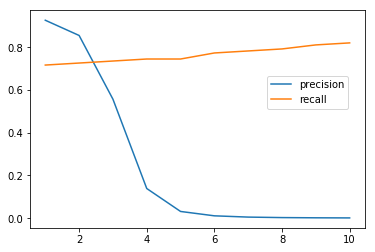

In [68]:
%matplotlib inline
import pylab

def accuracy(max_distance):
    similar = prod[prod.distance < max_distance]
    correct = float(sum(similar.cluster_x == similar.cluster_y))
    precision = correct / len(similar)
    recall = correct / len(clusters)
    return (precision, recall)

thresholds = range(1, 11)
p = []
r = []

for t in thresholds:
    acc = accuracy(t)
    p.append(acc[0])
    r.append(acc[1])

pylab.plot(thresholds, p)
pylab.plot(thresholds, r)
pylab.legend(['precision', 'recall'], bbox_to_anchor=(0.95, 0.7), loc=1, borderaxespad=0.)

**Question 4**

Another common way to visualize the tradeoff between precision and recall is to plot them directly against each other. Create a line plot with precision on one axis and recall on the other (this graph generated is called [precision-recall curve](https://www.quora.com/What-is-Precision-Recall-PR-curve)). Where are "good" points on the plot, and where are "bad" ones.(use recall as horizontal axis and precision as vertical axis)

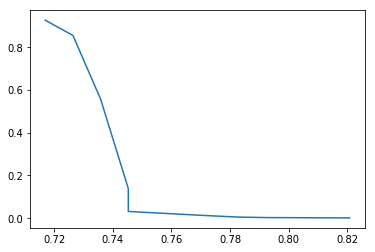

In [54]:
# Your answer here:
pylab.plot(r, p)

**Question 5**

The python Levenshtein library provides another metric of string similarity called "ratio" (use L.ratio(s1, s1)). ratio gives a similarity score between 0 and 1, with **higher meaning more similar**. Add a column to "prod" with the ratio similarities of the name columns, and redo the precision/recall tradeoff analysis with the new metric. (Note: you will have to alter the accuracy method and the threshold range.) On this data, does Levenshtein.ratio do better than Levenshtein.distance? (Plot the two precision-recall curves together in one graph to compare them)

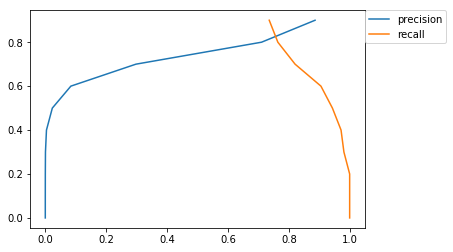

In [66]:
#Your answer here
prod['ratio'] = prod.apply(lambda row: L.ratio(row.name_x, row.name_y), axis=1)

def accuracy1(min_ratio):
    similar = prod[prod.ratio > min_ratio]
    correct = float(sum(similar.cluster_x == similar.cluster_y))
    precision = correct / len(similar)
    recall = correct / len(clusters)
    return (precision, recall)

import numpy as np
threshold = np.arange(0.0, 1.0, 0.1)
p1 = []
r1 = []

for t in threshold:
    acc = accuracy1(t)
    p1.append(acc[0])
    r1.append(acc[1])

pylab.plot(p1, threshold)
pylab.plot(r1, threshold)
pylab.legend(['precision', 'recall'], bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.)

## Homework

Please answer the questions 1 - 5 inlined in this ipython notebook.

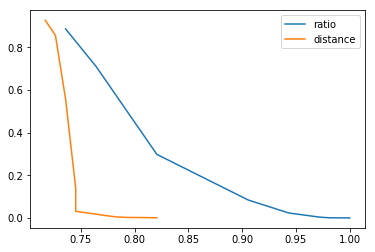

In [69]:
pylab.plot(r1, p1, label='ratio')
pylab.plot(r, p, label='distance')
pylab.legend(loc='best')